In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.regularizers import l2
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Greenland = pd.read_excel(filepath, sheet_name='Greenland-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Greenland)
fp.date_time(Greenland)

Extent       Date
0    1076123.146 1979-01-01
1    1099248.063 1979-02-01
2    1036964.901 1979-03-01
3     958927.937 1979-04-01
4     823812.694 1979-05-01
..           ...        ...
533   721350.515 2023-06-01
534   459033.164 2023-07-01
535   282045.909 2023-08-01
536   270397.608 2023-09-01
537   449910.973 2023-10-01

[538 rows x 2 columns]

In [5]:
fp.plot_df(Greenland)

In [6]:
scaler = MinMaxScaler()
Greenland['Extent'] = scaler.fit_transform(Greenland['Extent'].values.reshape(-1, 1))

In [7]:
extent = Greenland['Extent']
W_S=12
X,y = fp.df_to_X_y(extent, W_S)
X.shape, y.shape

((526, 12, 1), (526,))

In [8]:
X_shuffle, y_shuffle = shuffle(X, y, random_state=42)

In [12]:
def create_lstm():
    model = Sequential()
    model.add(InputLayer((W_S, 1)))
    model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])
    return model

In [13]:
def k_fold_cross_validation(X, y, scaler, k=5):
    tscv = TimeSeriesSplit(n_splits=k)
    mse_scores = []

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Create ModelCheckpoint callback
        checkpoint_filepath = f'Greenland_Try_{i + 1}.h5'
        model_checkpoint = ModelCheckpoint(checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

        model = create_lstm()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=10, callbacks=[model_checkpoint])

        # Load the best model based on validation loss
        model.load_weights(checkpoint_filepath)

        # Plot training and validation loss
        plt.plot(history.history['loss'], label=f'Training Loss - Fold {i + 1}')
        plt.plot(history.history['val_loss'], label=f'Validation Loss - Fold {i + 1}')

        # Make predictions on the test set
        y_pred_scaled = model.predict(X_test)
        y_test_scaled = y_test.reshape(-1, 1)

        # Inverse transform predictions and original test data
        y_pred = scaler.inverse_transform(y_pred_scaled)
        y_test_original = scaler.inverse_transform(y_test_scaled)

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred_scaled)
        mse_scores.append(mse)

        # Plot test predictions against original test data
        plt.figure(figsize=(15,6))
        plt.plot(y_test_original, label='True Values')
        plt.plot(y_pred, label='Predicted Values')
        plt.title(f'Test Predictions vs Original Test Data - Fold {i + 1}')
        plt.legend()
        plt.show()

    # Plot the training and validation loss after all folds
    plt.figure(figsize=(15,6))
    plt.plot(history.history['loss'], label='Overall Training Loss')
    plt.plot(history.history['val_loss'], label='Overall Validation Loss')
    plt.legend()
    plt.show()

    return mse_scores

Epoch 1/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.2875 - root_mean_squared_error: 0.5362
Epoch 1: val_loss improved from inf to 0.29322, saving model to Greenland_Try_1.h5
10/10 [==============================] - 7s 143ms/step - loss: 0.2845 - root_mean_squared_error: 0.5334 - val_loss: 0.2932 - val_root_mean_squared_error: 0.5415
Epoch 2/50
 8/10 [=======================>......] - ETA: 0s - loss: 0.2581 - root_mean_squared_error: 0.5081
Epoch 2: val_loss improved from 0.29322 to 0.27489, saving model to Greenland_Try_1.h5
10/10 [==============================] - 0s 51ms/step - loss: 0.2683 - root_mean_squared_error: 0.5180 - val_loss: 0.2749 - val_root_mean_squared_error: 0.5243
Epoch 3/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.2521 - root_mean_squared_error: 0.5021
Epoch 3: val_loss improved from 0.27489 to 0.25258, saving model to Greenland_Try_1.h5
10/10 [==============================] - 1s 54ms/step - loss: 0.2497 - root_mean_squared_error:

Epoch 25/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.0333 - root_mean_squared_error: 0.1825
Epoch 25: val_loss improved from 0.02880 to 0.02817, saving model to Greenland_Try_1.h5
10/10 [==============================] - 1s 53ms/step - loss: 0.0332 - root_mean_squared_error: 0.1823 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1679
Epoch 26/50
10/10 [==============================] - ETA: 0s - loss: 0.0353 - root_mean_squared_error: 0.1880
Epoch 26: val_loss improved from 0.02817 to 0.02771, saving model to Greenland_Try_1.h5
10/10 [==============================] - 0s 52ms/step - loss: 0.0353 - root_mean_squared_error: 0.1880 - val_loss: 0.0277 - val_root_mean_squared_error: 0.1665
Epoch 27/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.0344 - root_mean_squared_error: 0.1856
Epoch 27: val_loss did not improve from 0.02771
10/10 [==============================] - 0s 50ms/step - loss: 0.0343 - root_mean_squared_error: 0.1852 - val_loss: 0.0285 - va

 9/10 [==========================>...] - ETA: 0s - loss: 0.0207 - root_mean_squared_error: 0.1439
Epoch 49: val_loss did not improve from 0.01587
10/10 [==============================] - 0s 46ms/step - loss: 0.0208 - root_mean_squared_error: 0.1441 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1307
Epoch 50/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.0213 - root_mean_squared_error: 0.1458
Epoch 50: val_loss did not improve from 0.01587
3/3 [==============================] - 1s 12ms/step


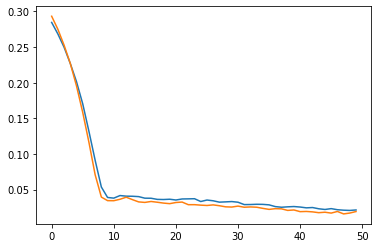

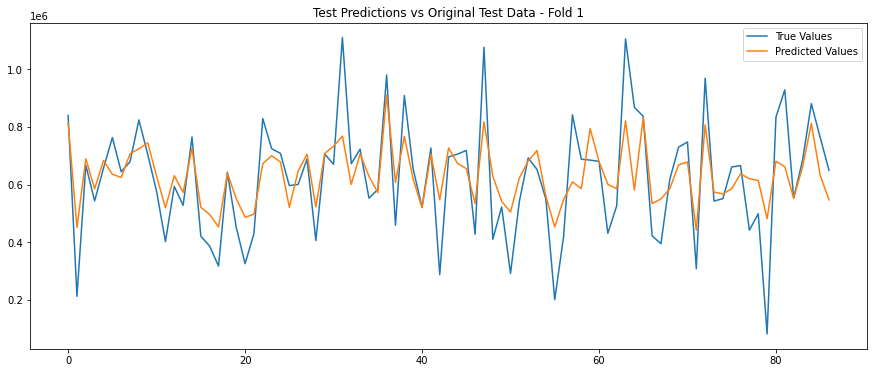

Epoch 1/50
17/18 [===========================>..] - ETA: 0s - loss: 0.2944 - root_mean_squared_error: 0.5426
Epoch 1: val_loss improved from inf to 0.28541, saving model to Greenland_Try_2.h5
18/18 [==============================] - 8s 90ms/step - loss: 0.2918 - root_mean_squared_error: 0.5402 - val_loss: 0.2854 - val_root_mean_squared_error: 0.5342
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.2583 - root_mean_squared_error: 0.5082
Epoch 2: val_loss improved from 0.28541 to 0.24783, saving model to Greenland_Try_2.h5
18/18 [==============================] - 1s 40ms/step - loss: 0.2583 - root_mean_squared_error: 0.5082 - val_loss: 0.2478 - val_root_mean_squared_error: 0.4978
Epoch 3/50
17/18 [===========================>..] - ETA: 0s - loss: 0.2193 - root_mean_squared_error: 0.4683
Epoch 3: val_loss improved from 0.24783 to 0.19755, saving model to Greenland_Try_2.h5
18/18 [==============================] - 1s 40ms/step - loss: 0.2152 - root_mean_squared_error: 

17/18 [===========================>..] - ETA: 0s - loss: 0.0192 - root_mean_squared_error: 0.1384
Epoch 24: val_loss improved from 0.02071 to 0.01851, saving model to Greenland_Try_2.h5
18/18 [==============================] - 1s 43ms/step - loss: 0.0200 - root_mean_squared_error: 0.1413 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1360
Epoch 25/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0181 - root_mean_squared_error: 0.1346
Epoch 25: val_loss improved from 0.01851 to 0.01695, saving model to Greenland_Try_2.h5
18/18 [==============================] - 1s 41ms/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1302
Epoch 26/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0176 - root_mean_squared_error: 0.1326
Epoch 26: val_loss improved from 0.01695 to 0.01602, saving model to Greenland_Try_2.h5
18/18 [==============================] - 1s 41ms/step - loss: 0.0179 - root_mean_squared_error: 0.

17/18 [===========================>..] - ETA: 0s - loss: 0.0147 - root_mean_squared_error: 0.1211
Epoch 48: val_loss did not improve from 0.01234
18/18 [==============================] - 1s 37ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1157
Epoch 49/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0159 - root_mean_squared_error: 0.1261
Epoch 49: val_loss did not improve from 0.01234
18/18 [==============================] - 1s 37ms/step - loss: 0.0157 - root_mean_squared_error: 0.1252 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 50/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0165 - root_mean_squared_error: 0.1283
Epoch 50: val_loss did not improve from 0.01234
3/3 [==============================] - 1s 12ms/step


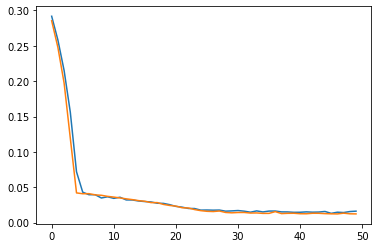

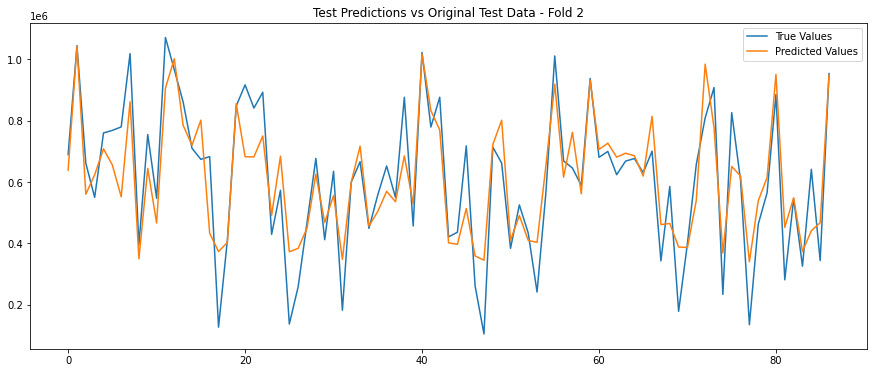

Epoch 1/50
25/27 [==========================>...] - ETA: 0s - loss: 0.2859 - root_mean_squared_error: 0.5347
Epoch 1: val_loss improved from inf to 0.24971, saving model to Greenland_Try_3.h5
27/27 [==============================] - 8s 66ms/step - loss: 0.2860 - root_mean_squared_error: 0.5348 - val_loss: 0.2497 - val_root_mean_squared_error: 0.4997
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 0.2357 - root_mean_squared_error: 0.4855
Epoch 2: val_loss improved from 0.24971 to 0.18658, saving model to Greenland_Try_3.h5
27/27 [==============================] - 1s 33ms/step - loss: 0.2357 - root_mean_squared_error: 0.4855 - val_loss: 0.1866 - val_root_mean_squared_error: 0.4320
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 0.1571 - root_mean_squared_error: 0.3964
Epoch 3: val_loss improved from 0.18658 to 0.09048, saving model to Greenland_Try_3.h5
27/27 [==============================] - 1s 27ms/step - loss: 0.1571 - root_mean_squared_error: 

27/27 [==============================] - ETA: 0s - loss: 0.0151 - root_mean_squared_error: 0.1229
Epoch 24: val_loss did not improve from 0.00703
27/27 [==============================] - 1s 35ms/step - loss: 0.0151 - root_mean_squared_error: 0.1229 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0867
Epoch 25/50
27/27 [==============================] - ETA: 0s - loss: 0.0170 - root_mean_squared_error: 0.1305
Epoch 25: val_loss did not improve from 0.00703
27/27 [==============================] - 1s 32ms/step - loss: 0.0170 - root_mean_squared_error: 0.1305 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0937
Epoch 26/50
26/27 [===========================>..] - ETA: 0s - loss: 0.0173 - root_mean_squared_error: 0.1317
Epoch 26: val_loss improved from 0.00703 to 0.00701, saving model to Greenland_Try_3.h5
27/27 [==============================] - 1s 36ms/step - loss: 0.0171 - root_mean_squared_error: 0.1309 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837
Epoch 27/50
27/27 

Epoch 49/50
27/27 [==============================] - ETA: 0s - loss: 0.0146 - root_mean_squared_error: 0.1209
Epoch 49: val_loss improved from 0.00582 to 0.00579, saving model to Greenland_Try_3.h5
27/27 [==============================] - 1s 36ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0761
Epoch 50/50
26/27 [===========================>..] - ETA: 0s - loss: 0.0142 - root_mean_squared_error: 0.1190
Epoch 50: val_loss did not improve from 0.00579
3/3 [==============================] - 1s 12ms/step


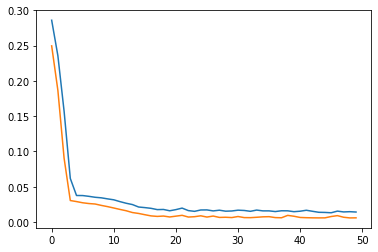

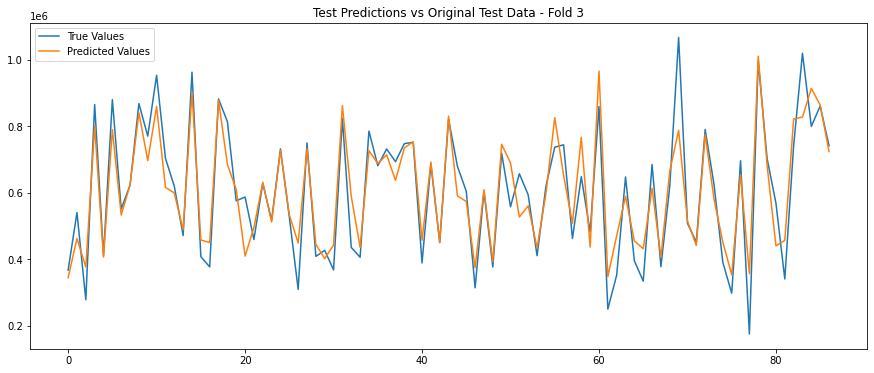

Epoch 1/50
34/36 [===========================>..] - ETA: 0s - loss: 0.2797 - root_mean_squared_error: 0.5289
Epoch 1: val_loss improved from inf to 0.26830, saving model to Greenland_Try_4.h5
36/36 [==============================] - 8s 57ms/step - loss: 0.2766 - root_mean_squared_error: 0.5260 - val_loss: 0.2683 - val_root_mean_squared_error: 0.5180
Epoch 2/50
35/36 [============================>.] - ETA: 0s - loss: 0.1961 - root_mean_squared_error: 0.4429
Epoch 2: val_loss improved from 0.26830 to 0.14705, saving model to Greenland_Try_4.h5
36/36 [==============================] - 1s 33ms/step - loss: 0.1963 - root_mean_squared_error: 0.4430 - val_loss: 0.1470 - val_root_mean_squared_error: 0.3835
Epoch 3/50
35/36 [============================>.] - ETA: 0s - loss: 0.0626 - root_mean_squared_error: 0.2501
Epoch 3: val_loss improved from 0.14705 to 0.03507, saving model to Greenland_Try_4.h5
36/36 [==============================] - 1s 33ms/step - loss: 0.0628 - root_mean_squared_error: 

36/36 [==============================] - 1s 31ms/step - loss: 0.0130 - root_mean_squared_error: 0.1140 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 25/50
36/36 [==============================] - ETA: 0s - loss: 0.0132 - root_mean_squared_error: 0.1149
Epoch 25: val_loss did not improve from 0.01024
36/36 [==============================] - 1s 31ms/step - loss: 0.0132 - root_mean_squared_error: 0.1149 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1098
Epoch 26/50
36/36 [==============================] - ETA: 0s - loss: 0.0133 - root_mean_squared_error: 0.1152
Epoch 26: val_loss did not improve from 0.01024
36/36 [==============================] - 1s 32ms/step - loss: 0.0133 - root_mean_squared_error: 0.1152 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1021
Epoch 27/50
34/36 [===========================>..] - ETA: 0s - loss: 0.0122 - root_mean_squared_error: 0.1106
Epoch 27: val_loss did not improve from 0.01024
36/36 [==============================] - 1s 31

36/36 [==============================] - 1s 31ms/step - loss: 0.0102 - root_mean_squared_error: 0.1010 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0991
Epoch 50/50
34/36 [===========================>..] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.1089
Epoch 50: val_loss did not improve from 0.00930
3/3 [==============================] - 1s 13ms/step


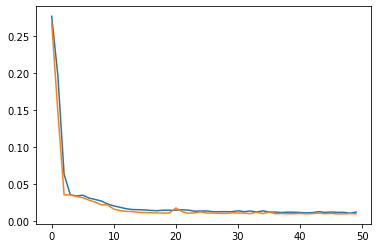

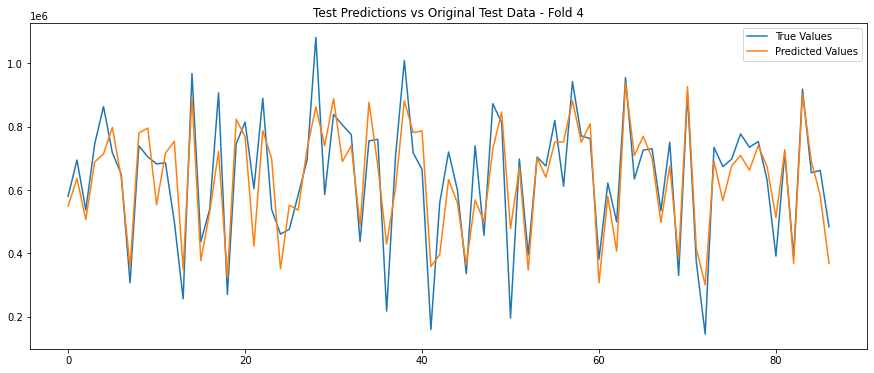

Epoch 1/50
43/44 [============================>.] - ETA: 0s - loss: 0.2914 - root_mean_squared_error: 0.5399
Epoch 1: val_loss improved from inf to 0.23958, saving model to Greenland_Try_5.h5
44/44 [==============================] - 9s 57ms/step - loss: 0.2908 - root_mean_squared_error: 0.5393 - val_loss: 0.2396 - val_root_mean_squared_error: 0.4895
Epoch 2/50
44/44 [==============================] - ETA: 0s - loss: 0.2154 - root_mean_squared_error: 0.4641
Epoch 2: val_loss improved from 0.23958 to 0.12949, saving model to Greenland_Try_5.h5
44/44 [==============================] - 2s 36ms/step - loss: 0.2154 - root_mean_squared_error: 0.4641 - val_loss: 0.1295 - val_root_mean_squared_error: 0.3598
Epoch 3/50
43/44 [============================>.] - ETA: 0s - loss: 0.0667 - root_mean_squared_error: 0.2584
Epoch 3: val_loss improved from 0.12949 to 0.03487, saving model to Greenland_Try_5.h5
44/44 [==============================] - 2s 35ms/step - loss: 0.0665 - root_mean_squared_error: 

44/44 [==============================] - 2s 35ms/step - loss: 0.0132 - root_mean_squared_error: 0.1151 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1073
Epoch 25/50
44/44 [==============================] - ETA: 0s - loss: 0.0132 - root_mean_squared_error: 0.1148
Epoch 25: val_loss improved from 0.01151 to 0.01124, saving model to Greenland_Try_5.h5
44/44 [==============================] - 2s 36ms/step - loss: 0.0132 - root_mean_squared_error: 0.1148 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1060
Epoch 26/50
44/44 [==============================] - ETA: 0s - loss: 0.0145 - root_mean_squared_error: 0.1203
Epoch 26: val_loss did not improve from 0.01124
44/44 [==============================] - 1s 34ms/step - loss: 0.0145 - root_mean_squared_error: 0.1203 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1066
Epoch 27/50
43/44 [============================>.] - ETA: 0s - loss: 0.0140 - root_mean_squared_error: 0.1183
Epoch 27: val_loss improved from 0.01124 to 0.01123, s

44/44 [==============================] - 2s 38ms/step - loss: 0.0118 - root_mean_squared_error: 0.1084 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0970
Epoch 49/50
43/44 [============================>.] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.1045
Epoch 49: val_loss did not improve from 0.00942
44/44 [==============================] - 1s 34ms/step - loss: 0.0109 - root_mean_squared_error: 0.1042 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0975
Epoch 50/50
43/44 [============================>.] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.1068
Epoch 50: val_loss improved from 0.00942 to 0.00937, saving model to Greenland_Try_5.h5
3/3 [==============================] - 1s 15ms/step


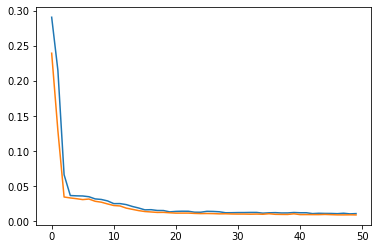

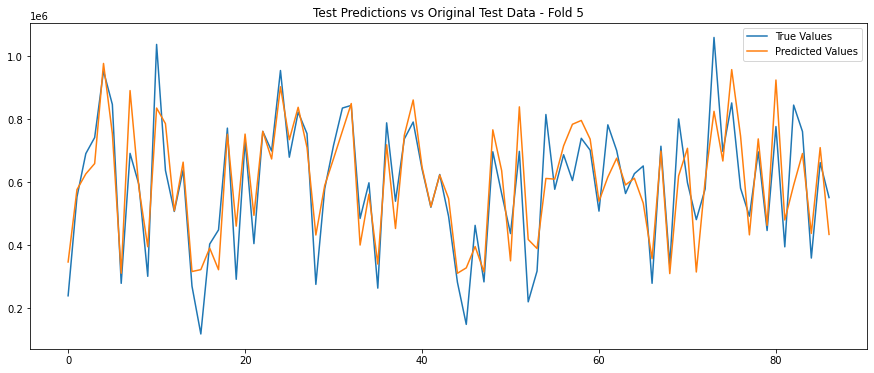

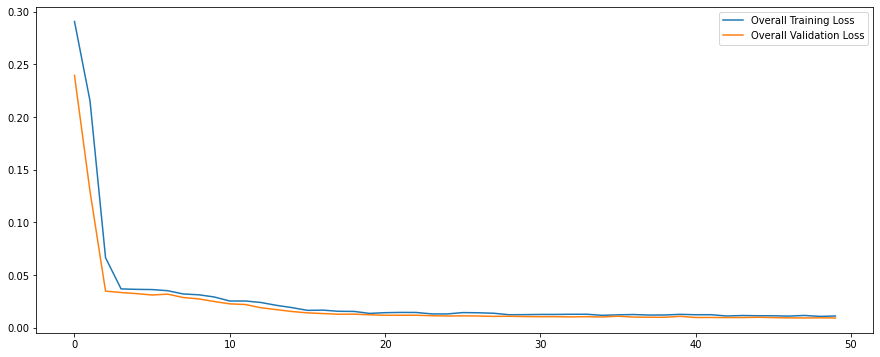

In [14]:
stime = time.time()
mse_scores = k_fold_cross_validation(X_shuffle, y_shuffle, scaler, k=5)
etime = time.time()

In [15]:
time = (etime - stime)/60
print(f'{time} minutes')

4.806441791852316 minutes


In [16]:
mse_scores

[0.01586565234944043,
 0.01233675047564854,
 0.005788203705645578,
 0.009295897234196465,
 0.009367603188247819]

In [17]:
print("Mean MSE:", np.mean(mse_scores))
print("Std MSE:", np.std(mse_scores))

Mean MSE: 0.010530821390635766
Std MSE: 0.0033791223115957614


In [18]:
mse = np.mean(mse_scores)
rmse = np.sqrt(mse)
rmse

0.10261979044334366

In [19]:
from tensorflow.keras.models import load_model

In [20]:
model1 = load_model('Greenland_Try_5.h5')

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 14ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

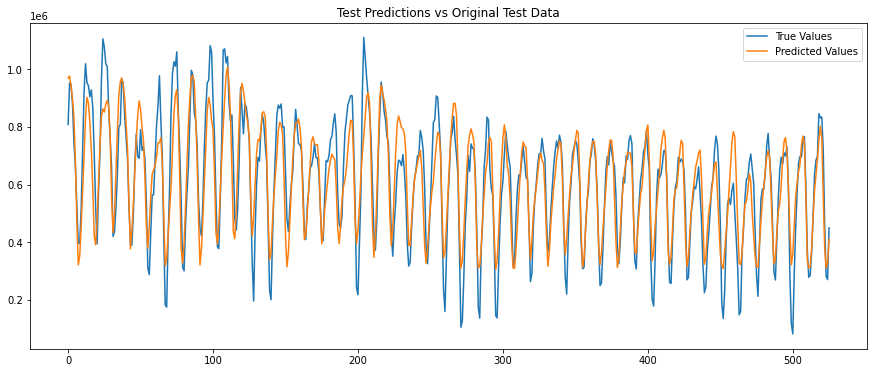

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [24]:
df_original = pd.DataFrame({'Actual Extent' : Original.flatten(), 'Train Predictions': predictions.flatten()})

In [25]:
fp.train_vs_actual_plot(df_original)

In [26]:
from sklearn.metrics import r2_score

r2 = r2_score(Original, predictions)
print(r2)

0.7776002666144843
